## Basic Clustering of Prenatal Samples 

In [1]:
!date

Sat Apr 22 15:39:03 PDT 2023


In [2]:
!echo $CONDA_PREFIX

/c4/home/derek/miniconda3/envs/SCVI


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import scanpy as sc
import anndata
import matplotlib.pyplot as plt

import scvi

import warnings
warnings.filterwarnings('ignore')


Global seed set to 0
/c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [4]:
pwd

'/nowakowskilab/data1/derek/scSLR/notebooks/fig3'

### load raw STAR Solo outputs and filter by counts

In [5]:
# import sys
# !conda install --yes --prefix {sys.prefix} scanpy 

In [6]:
input_dir = "/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/STAR_outs/"

In [7]:
%%time
adatas = {}
samples = ["GW16_1", "GW16_2", "GW17_1", "GW21_1", "GW21_2", "GW23_1"]
for sample in samples:
    print("getting " + sample+ " matrix")

    adata_sample = sc.read_mtx(input_dir+f"/{sample}/StarOut/Solo.out/GeneFull/raw/matrix.mtx").T
    adata_sample.obs_names = pd.read_csv(input_dir+f"/{sample}/StarOut/Solo.out/GeneFull/raw/barcodes.tsv",header=None)[0]
    adata_sample.var_names = pd.read_csv(input_dir+f"/{sample}/StarOut/Solo.out/GeneFull/raw/features.tsv",header=None,sep='\t')[1]  
    
    adata_sample.var_names_make_unique()

    adatas[sample] = adata_sample

getting GW16_1 matrix
getting GW16_2 matrix
getting GW17_1 matrix
getting GW21_1 matrix
getting GW21_2 matrix
getting GW23_1 matrix
CPU times: user 10min 1s, sys: 15.9 s, total: 10min 17s
Wall time: 10min 17s


In [8]:
adatas

{'GW16_1': AnnData object with n_obs × n_vars = 6794880 × 36385,
 'GW16_2': AnnData object with n_obs × n_vars = 6794880 × 36385,
 'GW17_1': AnnData object with n_obs × n_vars = 6794880 × 36385,
 'GW21_1': AnnData object with n_obs × n_vars = 6794880 × 36385,
 'GW21_2': AnnData object with n_obs × n_vars = 6794880 × 36385,
 'GW23_1': AnnData object with n_obs × n_vars = 6794880 × 36385}

In [9]:
for batch in adatas:
    ad = adatas[batch]
    sc.pp.filter_cells(ad,min_counts=200,inplace=True)

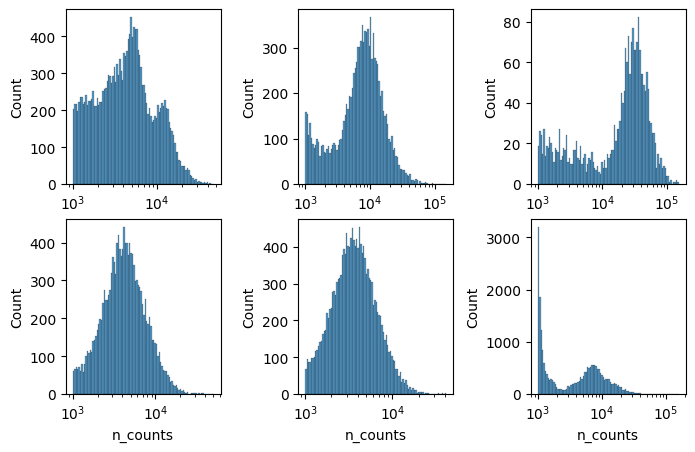

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5))

for batch, ax in zip(adatas,axes.ravel()):
    
    ad = adatas[batch]
    ad = ad[ad.obs["n_counts"] >= 1000]
    sns.histplot(ad.obs["n_counts"],ax=ax, bins=100,kde=False,log_scale =True)


fig.subplots_adjust(wspace=0.5)

In [11]:
thresholds = {'GW16_1':1000,
              'GW16_2':2000,
              'GW17_1':6000,
              'GW21_1':1000,
              'GW21_2':1000,
              'GW23_1':2000
             }

In [12]:

for batch, threshold in zip(adatas, thresholds):
    threshold = thresholds[batch]
    print(batch + " thrshold at: " +str(threshold))
    print(batch)
    
    ad = adatas[batch]
    
    sc.pp.filter_cells(ad, min_counts=threshold, inplace=True)


GW16_1 thrshold at: 1000
GW16_1
GW16_2 thrshold at: 2000
GW16_2
GW17_1 thrshold at: 6000
GW17_1
GW21_1 thrshold at: 1000
GW21_1
GW21_2 thrshold at: 1000
GW21_2
GW23_1 thrshold at: 2000
GW23_1


In [13]:
adata = anndata.concat(adatas, index_unique="-", merge="same", label='batch')
adata

AnnData object with n_obs × n_vars = 75666 × 36385
    obs: 'n_counts', 'batch'

In [14]:
adata

AnnData object with n_obs × n_vars = 75666 × 36385
    obs: 'n_counts', 'batch'

In [15]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")

In [16]:
sc.pp.calculate_qc_metrics(adata,inplace=True,qc_vars=["mito"])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [17]:
del adata.obs['pct_counts_in_top_50_genes']
del adata.obs['pct_counts_in_top_100_genes']
del adata.obs['pct_counts_in_top_200_genes']
del adata.obs['pct_counts_in_top_500_genes']
del adata.obs['total_counts_mito']
del adata.obs['log1p_total_counts_mito']
#del adata.obs['n_genes']

### batch integration by SCVI 

In [18]:
#sc.experimental.pp.recipe_pearson_residuals(adata,batch_key='batch')

In [19]:
adata.raw = adata.copy()

sc.pp.filter_genes(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()


sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [20]:
# adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True
)

In [21]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [22]:
#vae = scvi.model.SCVI(adata)

vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")


In [23]:
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 106/106: 100%|███████| 106/106 [32:12<00:00, 16.54s/it, loss=785, v_num=1]

`Trainer.fit` stopped: `max_epochs=106` reached.


Epoch 106/106: 100%|███████| 106/106 [32:12<00:00, 18.23s/it, loss=785, v_num=1]


In [25]:
vae.save('/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/SCVI/cbatch_corr_VAE')

In [26]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [27]:
sc.pp.neighbors(adata,
                use_rep="X_scVI",
               # n_pcs=30,
               # n_neighbors=15
               )

In [28]:
sc.tl.umap(adata,
           # n_components=2,     
           # min_dist =.3,
           # spread =2
          )

In [29]:
sc.tl.leiden(adata,resolution=1.5)

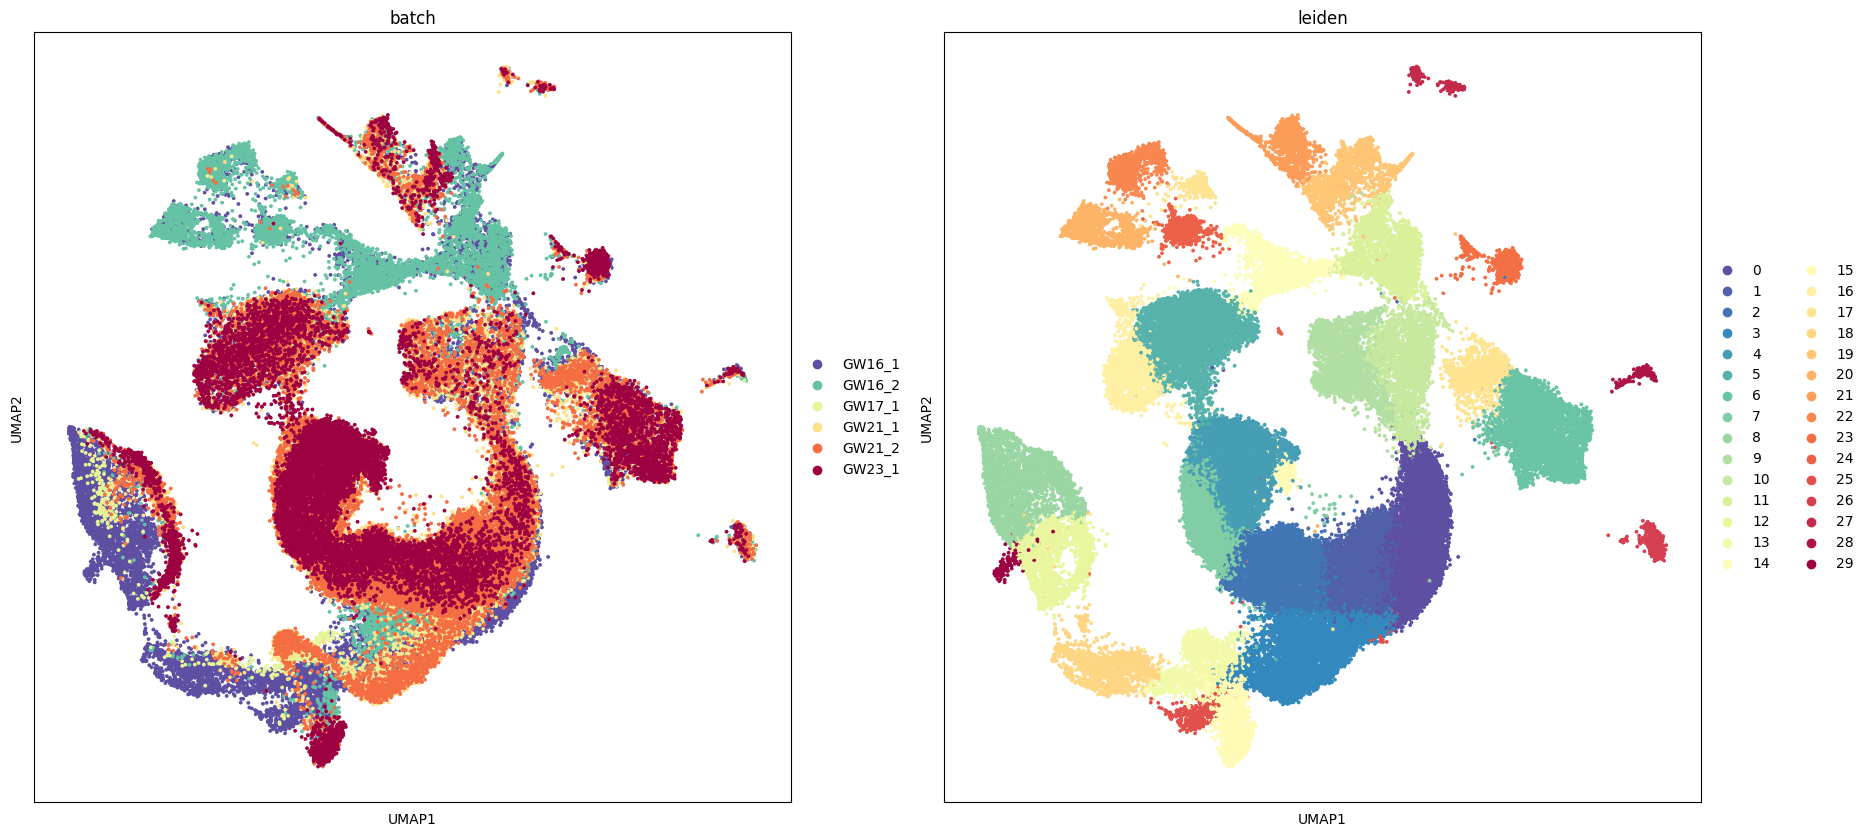

In [30]:
plt.rcParams['figure.figsize']=10,10

sc.pl.umap(adata,color=['batch','leiden',
                        #  'EOMES','NEUROG2','NEUROD2','SATB2',
                        #   'DLX2','LHX6','SP8',
                        # 'PAX6','ETV1','AIF1',
                        #   'ROBO2','RARB','OLIG1','FOXP1'
                       ],
          # vmax='p99',
           size=30,
           ncols=2,
           palette='Spectral_r'
           # groups=['GW16_1',
           #        # 'GW16_2'
           #       ]
          )

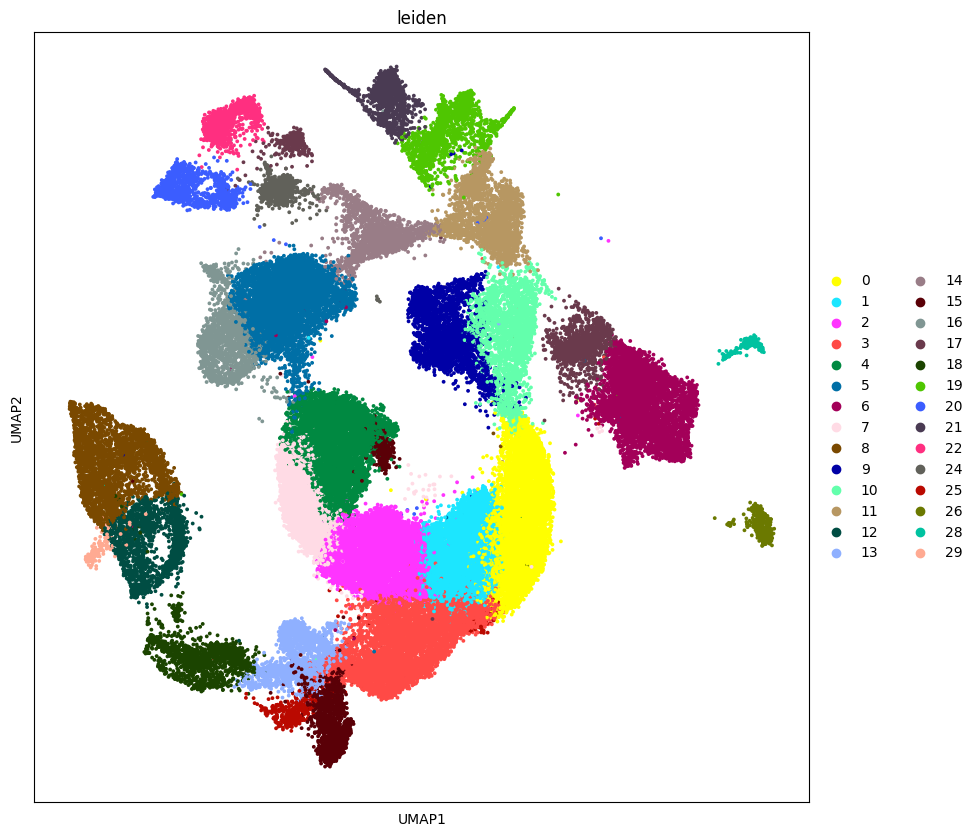

In [31]:
      
sc.pl.umap(adata[~adata.obs.leiden.isin(['23','27','30'])],
           color=['leiden'],
           size=30,
           ncols=2,
           palette=sc.pl.palettes.default_102, #'Spectral_r'
            # groups=['25'
            #       ]
          )

In [32]:
adata_ = adata[~adata.obs.leiden.isin(['23','27','30'])]

In [33]:
adata_.write_h5ad('SCVI_clean.h5ad')

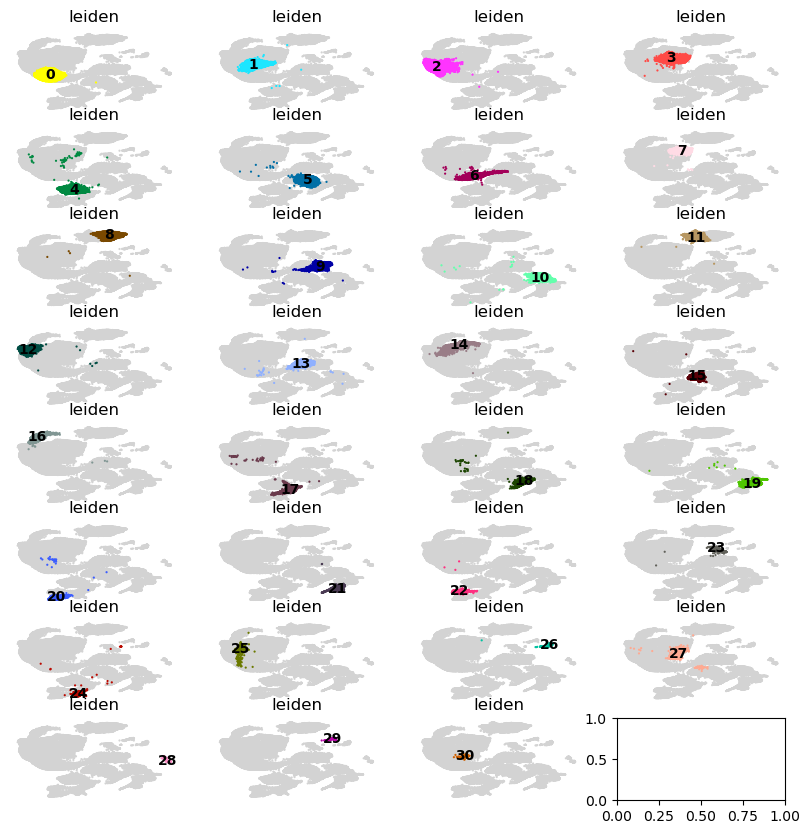

In [84]:
fig, axs = plt.subplots(nrows=8, ncols=4)

#plt.subplots_adjust(wspace=1,hspace=.5)

for i, ax in zip(adata.obs.leiden.cat.categories.tolist(), axs.ravel()):
    sc.pl.umap(adata,color=['leiden'],
           vmax='p99',
           size=10,
           ncols=1,
           groups=[i],
           ax=ax,
           show=False,
           na_in_legend=False,
           legend_loc='on data',
           frameon=False
          )

plt.show()

In [243]:
##write out barcode lists

# pd.DataFrame(adata[adata.obs.batch == 'GW16_1'].obs_names.str[:-7]).to_csv('GW16_1_barcodes.csv',header=None,index=None)
# pd.DataFrame(adata[adata.obs.batch == 'GW16_2'].obs_names.str[:-7]).to_csv('GW16_2_barcodes.csv',header=None,index=None)
# pd.DataFrame(adata[adata.obs.batch == 'GW17'].obs_names.str[:-5]).to_csv('GW17_1_barcodes.csv',header=None,index=None)
# pd.DataFrame(adata[adata.obs.batch == 'GW21_1'].obs_names.str[:-7]).to_csv('GW21_1_barcodes.csv',header=None,index=None)
# pd.DataFrame(adata[adata.obs.batch == 'GW21_2'].obs_names.str[:-7]).to_csv('GW21_2_barcodes.csv',header=None,index=None)
# pd.DataFrame(adata[adata.obs.batch == 'GW23'].obs_names.str[:-5]).to_csv('GW23_1_barcodes.csv',header=None,index=None)

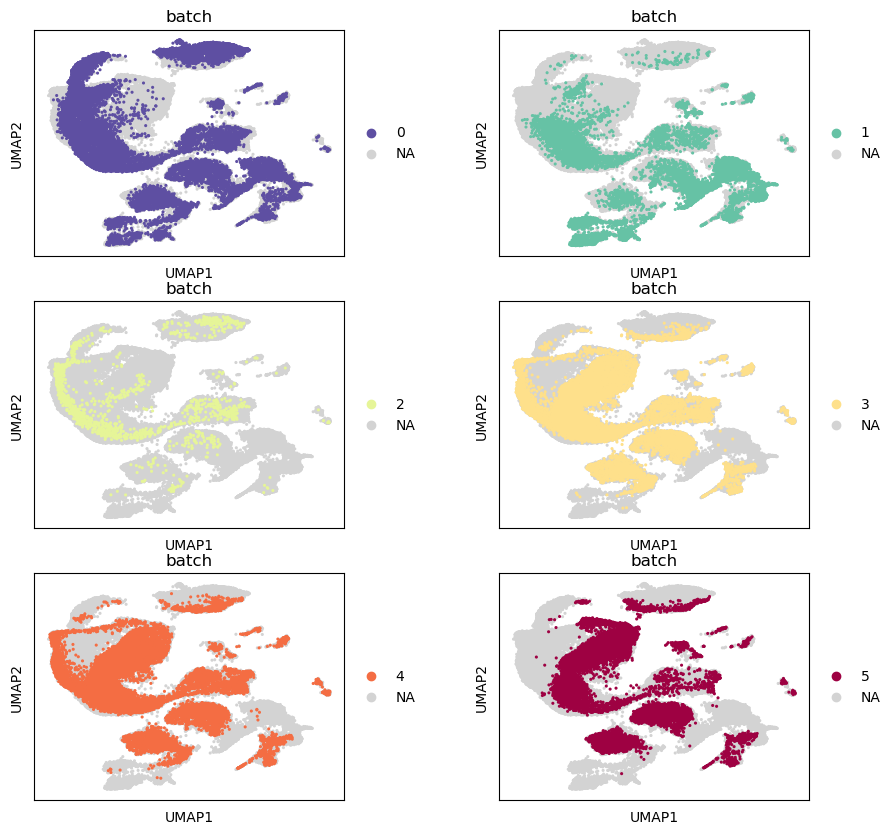

In [112]:
fig, axs = plt.subplots(nrows=3, ncols=2)

plt.subplots_adjust(wspace=0.5)

for i, ax in zip(adata.obs.batch.cat.categories.tolist(), axs.ravel()):
    sc.pl.umap(adata,color=['batch'],
           vmax='p99',
           size=20,
           ncols=1,
           groups=[i],
           ax=ax,
           show=False
          )
    
plt.show()


In [114]:
batch_dict = {'-0':'-GW16_1',
              '-1':'-GW16_2',
              '-2':'-GW17_1',
              '-3':'-GW21_1',
              '-4':'-GW21_2',
              '-5':'-GW23_1'
             }
    

In [115]:
new_names = adata.obs_names.copy()

for key, value in batch_dict.items():
    new_names = new_names.str.replace(key, value)

In [116]:
adata.obs['alt_obs_names'] = new_names

In [118]:
#adata=sc.read_h5ad('SCVI.h5ad')

In [120]:
adata.obs

,n_counts,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_mito,_scvi_batch,_scvi_labels,leiden,alt_obs_names
AAACCCAAGAACCGCA-0,5027.0,0,2618,7.870548,5027.0,8.522778,4.356475,0,0,0,AAACCCAAGAACCGCA-GW16_1
AAACCCAAGCAACAGC-0,6498.0,0,2982,8.000685,6498.0,8.779404,3.985842,0,0,11,AAACCCAAGCAACAGC-GW16_1
AAACCCAAGCCTGGAA-0,4639.0,0,2487,7.819234,4639.0,8.442470,1.832291,0,0,3,AAACCCAAGCCTGGAA-GW16_1
AAACCCACAAACCACT-0,1972.0,0,1319,7.185387,1972.0,7.587310,1.926978,0,0,0,AAACCCACAAACCACT-GW16_1
AAACCCACACCAGCCA-0,6391.0,0,3199,8.070906,6391.0,8.762802,5.711156,0,0,7,AAACCCACACCAGCCA-GW16_1
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCCGTAGTA-5,2241.0,5,1434,7.268920,2241.0,7.715124,2.052655,5,0,3,TTTGTTGTCCGTAGTA-GW23_1
TTTGTTGTCCTGTTGC-5,6845.0,5,2967,7.995644,6845.0,8.831420,7.363039,5,0,1,TTTGTTGTCCTGTTGC-GW23_1
TTTGTTGTCTCAAAGC-5,5440.0,5,2678,7.893199,5440.0,8.601718,2.702206,5,0,1,TTTGTTGTCTCAAAGC-GW23_1
TTTGTTGTCTGTAAGC-5,9132.0,5,3735,8.225771,9132.0,9.119650,5.256242,5,0,4,TTTGTTGTCTGTAAGC-GW23_1


In [39]:
adata.obs['scANVI_simple'] = pd.read_csv('./scANVI_annotations.csv',index_col=0)

In [41]:
#adata.obs['age'] = adata.obs['alt_obs_names'].str[-6:].str[:-2].astype('category') 

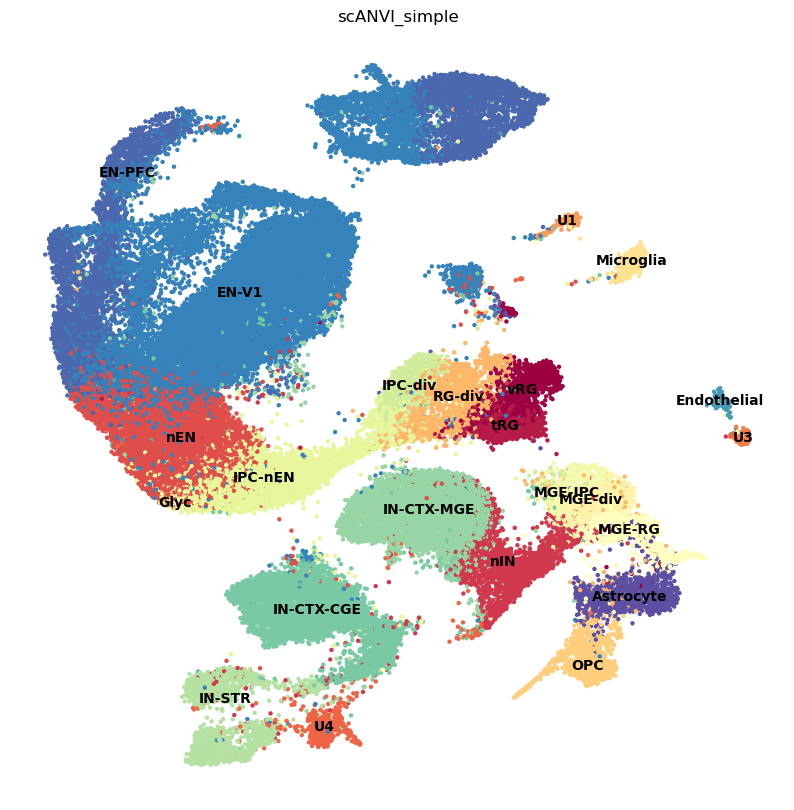

In [44]:
plt.rcParams['figure.figsize']=10,10

sc.pl.umap(adata,color=['scANVI_simple',
                        # 'leiden',
                        # 'age'
                       ],
           vmax='p99',
           size=40,
           ncols=4,
           palette='Spectral_r',
           legend_loc='on data',
           frameon=False,
          )

In [42]:
#adata.write_h5ad('SCVI.h5ad')

In [137]:
df = adata.obs.groupby('scANVI_simple')['age'].value_counts(normalize=True)

df = pd.DataFrame(df).unstack()  

df.columns = df.columns.droplevel(0)

colormap = dict(zip(adata.obs['age'].cat.categories.tolist(),adata.uns['age_colors']))

<AxesSubplot: xlabel='scANVI_simple'>

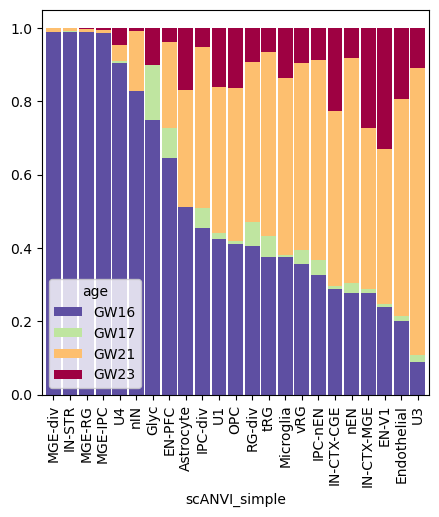

In [139]:
plt.rcParams["figure.figsize"] = 5,5

df.sort_values(by='GW16',ascending=False).plot.bar(stacked=True,color=colormap,width=.9)

'/nowakowskilab/data1/derek/scSLR/notebooks/fig3'

In [13]:
input_dir = "/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/"

#adata.write_h5ad('SCVI_.h5ad')
adata = sc.read_h5ad(input_dir+'scANVI_label.h5ad')

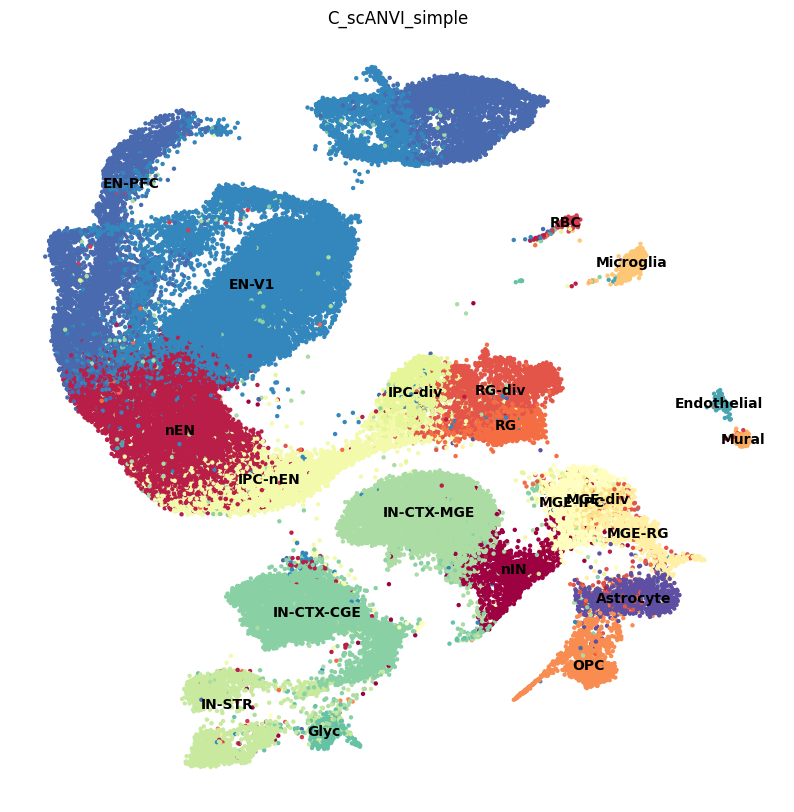

In [15]:
plt.rcParams['figure.figsize']=10,10

sc.pl.umap(adata,color=['C_scANVI_simple',
                        # 'leiden',
                        # 'age'
                       ],
           vmax='p99',
           size=40,
           ncols=4,
           palette='Spectral_r',
           legend_loc='on data',
           frameon=False,
          )

In [18]:
adata.obs

,n_counts,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_mito,_scvi_batch,_scvi_labels,leiden,scANVI_simple,tech,C_scANVI,C_scANVI_simple
AAACCCAAGAACCGCA-0,5027.0,0,2618,7.870548,5027.0,8.522778,4.356475,0,0,0,IPC-nEN,SLR,IPC-nEN2,IPC-nEN
AAACCCAAGCAACAGC-0,6498.0,0,2982,8.000685,6498.0,8.779404,3.985842,0,0,16,EN-V1,SLR,EN-PFC2,EN-PFC
AAACCCAAGCCTGGAA-0,4639.0,0,2487,7.819234,4639.0,8.442470,1.832291,0,0,5,IN-CTX-MGE,SLR,IN-CTX-MGE2,IN-CTX-MGE
AAACCCACAAACCACT-0,1972.0,0,1319,7.185387,1972.0,7.587310,1.926978,0,0,0,nEN,SLR,nEN-late,nEN
AAACCCACACCAGCCA-0,6391.0,0,3199,8.070906,6391.0,8.762802,5.711156,0,0,13,IPC-div,SLR,IPC-div2,IPC-div
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCCGTAGTA-5,2241.0,5,1434,7.268920,2241.0,7.715124,2.052655,5,0,5,IN-CTX-MGE,SLR,IN-CTX-MGE1,IN-CTX-MGE
TTTGTTGTCCTGTTGC-5,6845.0,5,2967,7.995644,6845.0,8.831420,7.363039,5,0,3,EN-V1,SLR,EN-V1-3,EN-V1
TTTGTTGTCTCAAAGC-5,5440.0,5,2678,7.893199,5440.0,8.601718,2.702206,5,0,3,EN-V1,SLR,EN-V1-3,EN-V1
TTTGTTGTCTGTAAGC-5,9132.0,5,3735,8.225771,9132.0,9.119650,5.256242,5,0,14,EN-V1,SLR,EN-V1-3,EN-V1


In [17]:
adata.obs['age'] = adata.obs['alt_obs_names'].str[-6:].str[:-2].astype('category') 

KeyError: 'alt_obs_names'

In [16]:
df = adata.obs.groupby('C_scANVI_simple')['age'].value_counts(normalize=True)

df = pd.DataFrame(df).unstack()  

df.columns = df.columns.droplevel(0)

colormap = dict(zip(adata.obs['age'].cat.categories.tolist(),adata.uns['age_colors']))

KeyError: 'Column not found: age'

In [ ]:
plt.rcParams["figure.figsize"] = 5,5

df.sort_values(by='GW16',ascending=False).plot.bar(stacked=True,color=colormap,width=.9)

In [ ]:
adata

In [157]:
colors = pd.DataFrame(zip(adata.obs['scANVI_simple'].cat.categories,adata.uns['scANVI_simple_colors']),
                      columns=['celltype','color'])

In [159]:
colors.to_csv('celltpye_colors.csv')

In [140]:
!conda list

# packages in environment at /home/derek/miniconda3/envs/SCVI_2:
#
# Name                    Version                   Build  Channel
_ipython_minor_entry_point 8.7.0                h8cf3c4a_0    conda-forge
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                  2_kmp_llvm    conda-forge
absl-py                   1.2.0                    pypi_0    pypi
aiohttp                   3.8.1                    pypi_0    pypi
aiosignal                 1.2.0                    pypi_0    pypi
altair                    4.2.0              pyhd8ed1ab_1    conda-forge
anndata                   0.8.0              pyhd8ed1ab_1    conda-forge
anyio                     3.6.2              pyhd8ed1ab_0    conda-forge
aom                       3.5.0                h27087fc_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hb9d737c_3    conda-forge
asttokens 